(c) 2021, Franz Ludwig Kostelezky, IMTEK chair of simulation, \<info@kostelezky.com\>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from datetime import datetime

In [2]:
# import physiobank ecg data
data_physionet = pd.read_csv('./ECG_data/physionet/ecg_id_01_1.csv', sep=",", header=2)
data_physionet.columns = ['time', 'ECG I', 'ECG I filtered']

In [3]:
t_max = 20 # s
len_series = len(data_physionet['ECG I'])
sample_frequency = len_series / t_max
t = np.linspace(0, t_max, len_series)

<IPython.core.display.Javascript object>


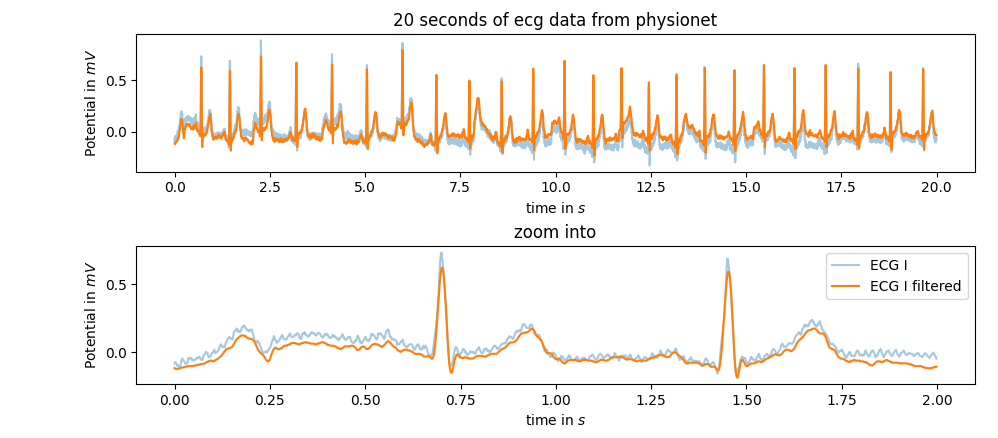

In [4]:
%matplotlib notebook
plt.subplot(2, 1, 1)
plt.title('20 seconds of ecg data from physionet')
plt.plot(t, data_physionet['ECG I'], alpha=.4, label='ECG I')
plt.plot(t, data_physionet['ECG I filtered'], label='ECG I filtered')
plt.xlabel('time in $s$')
plt.ylabel('Potential in $mV$')
plt.subplot(2, 1, 2)
plt.title('zoom into')
plt.plot(t[:1000], data_physionet['ECG I'][:1000], alpha=.4, label='ECG I')
plt.plot(t[:1000], data_physionet['ECG I filtered'][:1000], label='ECG I filtered')
plt.xlabel('time in $s$')
plt.ylabel('Potential in $mV$')
plt.legend()
plt.tight_layout()
plt.show()

In [5]:
# original time series
series_np = np.array(data_physionet['ECG I filtered'])
print('validation before cut:', series_np[0] == series_np[-1])

# these are the points where the periodical condition is true
# we cut at the last possible point
o = np.where(series_np == series_np[0])
series_np_cut = series_np[0:o[0][10] + 1]

# validating cut
print('validation after cut:', series_np_cut[0] == series_np_cut[0])

validation before cut: False
validation after cut: True


In [6]:
def five_point_derivate_periodic(series):
    ''' Returns the 1D second order upwind derivate of a one dimensional
    time series using reflecting boundary conditions.
    '''

    series = np.array(series)
    dx = 1
    d_pos = (- 3 * series \
             + 4 * np.roll(series, shift=-1, axis=0) \
             - np.roll(series, shift=-2, axis=0)
            ) / (2 * dx)
    d_neg = (+ 3 * series \
             - 4 * np.roll(series, shift=1, axis=0) \
             + np.roll(series, shift=2, axis=0)
            ) / (2 * dx)
    derivate = d_pos
    derivate[-3::] = d_neg[-3::]

    return derivate

In [16]:
series = series_np_cut
series_derivate = five_point_derivate_periodic(series)
series_min = min(series)
series_max = max(series)

# Fit to a non-oscillator ode
Just like C.Uhl in his book, we fit $f(y)$ to $\dot{y}$.

With a fit-polynominal:

$$
f(y) = a_0y+a_1y^2+y_2y^3+a_3y^4+a_4y^5+...
$$

In [123]:
def solve_eqs_for_a(y, z):
    a = [[np.sum(y ** 2), np.sum(y ** 3), np.sum(y ** 4), np.sum(y ** 5), np.sum(y ** 6), np.sum(y ** 7)],
         [np.sum(y ** 3), np.sum(y ** 4), np.sum(y ** 5), np.sum(y ** 6), np.sum(y ** 7), np.sum(y ** 8)],
         [np.sum(y ** 4), np.sum(y ** 5), np.sum(y ** 6), np.sum(y ** 7), np.sum(y ** 8), np.sum(y ** 9)],
         [np.sum(y ** 5), np.sum(y ** 6), np.sum(y ** 7), np.sum(y ** 8), np.sum(y ** 9), np.sum(y ** 10)],
         [np.sum(y ** 6), np.sum(y ** 7), np.sum(y ** 8), np.sum(y ** 9), np.sum(y ** 10), np.sum(y ** 11)],
         [np.sum(y ** 7), np.sum(y ** 8), np.sum(y ** 9), np.sum(y ** 10), np.sum(y ** 11), np.sum(y ** 12)],]
    b = [[np.sum(z * y)],
         [np.sum(z * y ** 2)],
         [np.sum(z * y ** 3)],
         [np.sum(z * y ** 4)],
         [np.sum(z * y ** 5)],
         [np.sum(z * y ** 6)],]
    
    return np.linalg.solve(a, b)

In [124]:
def convert_coeffictents_to_fit_function(p):
    def func(y):
        res = 0
        for i in range(len(p)):
            res += p[i] * y ** (i + 2)
        return res
    return func

In [125]:
p = solve_eqs_for_a(series, series_derivate)

In [126]:
p_ = convert_coeffictents_to_fit_function(p)

<IPython.core.display.Javascript object>


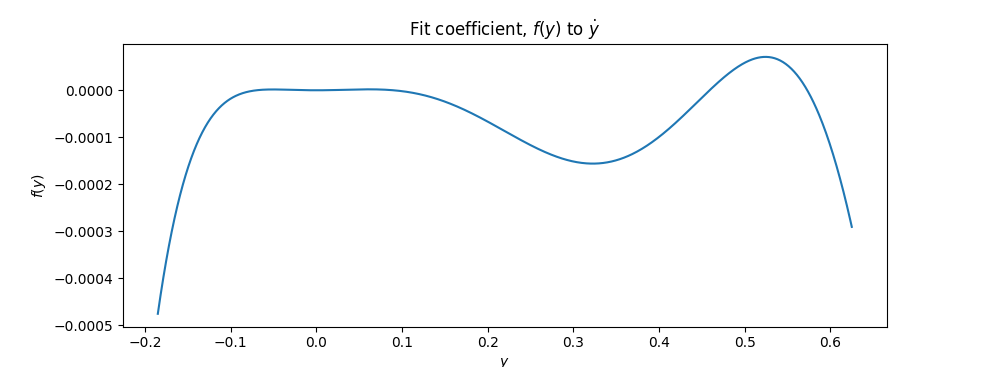

In [127]:
%matplotlib notebook
y = np.linspace(series_min, series_max, 1000)
plt.plot(y, p_(y))
plt.title('Fit coefficient, $f(y)$ to $\dot{y}$')
plt.xlabel('$y$')
plt.ylabel('$f(y)$')
plt.show()

## Without noise

In [207]:
def func(t, x, fit_to_y):
    '''
    '''
    y = [0]

    y[0] = fit_to_y(x[0])
    return y

In [208]:
T = len(series)
T = 14000 # shorter computation time

ivp = [0]
index_start = 341
ivp[0] += series[index_start]

sol = solve_ivp(func, [0, T], [ivp[0]], dense_output=True, args=[p_])

In [209]:
f = 1
t = np.linspace(0, T, T*f)
y = sol.sol(t)

res = (t, y)

<IPython.core.display.Javascript object>


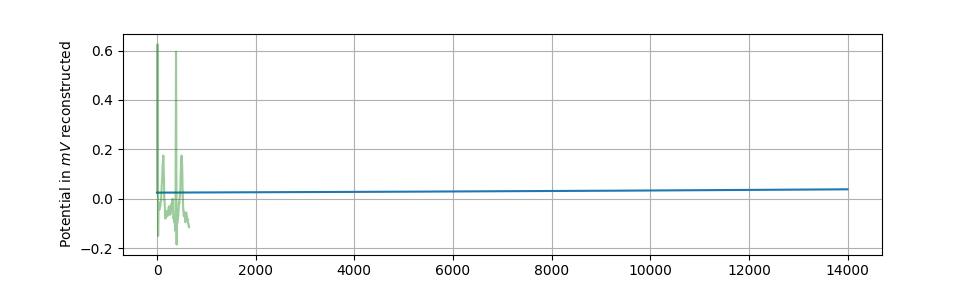

In [210]:
%matplotlib notebook
mi = -1
plt.plot(res[0][:mi], res[1][0][:mi])
plt.plot(series[index_start:], alpha=.4, c='g')
plt.xlabel('timestep $t$')
plt.ylabel('Potential in $mV$ reconstructed')
plt.grid()
plt.show()

## With noise

In [196]:
sigma = abs(p[2][0])
sigma

0.20650396600838558

In [217]:
def func(t, x, fit_to_y):
    '''
    '''
    y = [0]

    y[0] = fit_to_y(x[0]) + sigma*np.random.normal(scale=sigma**2)
    return y

In [218]:
T = len(series)
T = 14000 # shorter computation time

ivp = [0]
index_start = 341
ivp[0] += series[index_start]

sol = solve_ivp(func, [0, T], [ivp[0]], dense_output=True, args=[p_])

In [219]:
f = 1
t = np.linspace(0, T, T*f)
y = sol.sol(t)

res = (t, y)

<IPython.core.display.Javascript object>


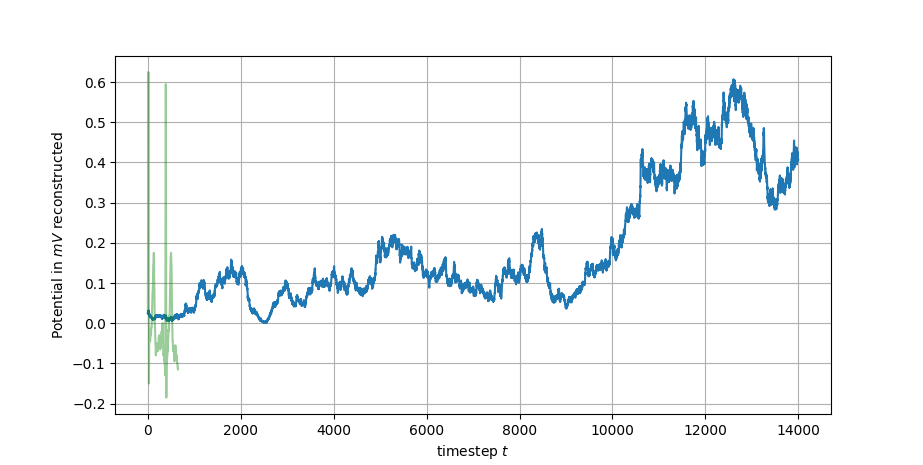

In [220]:
%matplotlib notebook
mi = -1
plt.plot(res[0][:mi], res[1][0][:mi])
plt.plot(series[index_start:], alpha=.4, c='g')
plt.xlabel('timestep $t$')
plt.ylabel('Potential in $mV$ reconstructed')
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


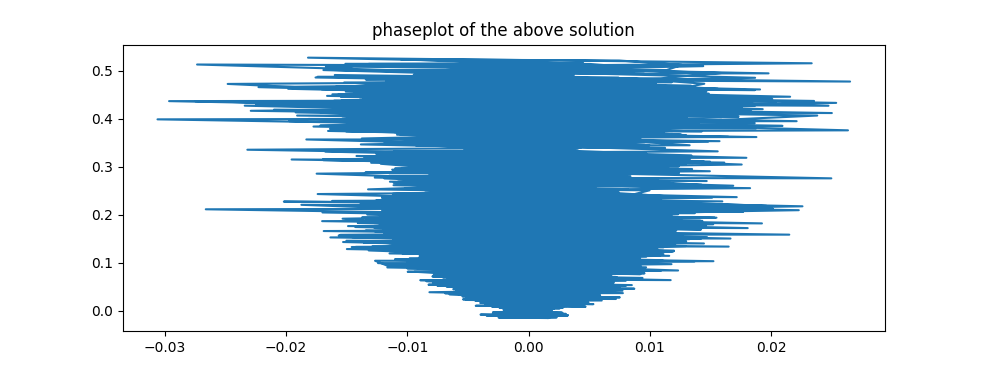

In [206]:
%matplotlib notebook
plt.title('phaseplot of the above solution')
plt.plot(five_point_derivate_periodic(res[1][0]), res[1][0])